# **Project**

**step 1**: import all dependencies and inspect data
- _Seems as though there's extra data here so will plot to see what it means_

In [3]:
import pandas as pd
import neural as nl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier as classify
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV as gridsearch

data = pd.read_csv('./data/SDSS_galaxies.csv')
data.head()

u         g         r         i         z specClass  redshift  \
0  18.31537  17.03378  16.43044  16.07336  15.79528    GALAXY  0.057006   
1  19.56470  17.89683  16.79172  16.30632  15.94328    GALAXY  0.152668   
2  19.25199  19.00241  18.72587  18.55749  18.58451       QSO  1.448379   
3  19.30206  17.12601  16.01106  15.51805  15.05948    GALAXY  0.105601   
4  18.39921  17.21244  16.64964  16.36866  16.19744    GALAXY  0.032242   

   redshift_err  
0      0.000007  
1      0.000030  
2      0.000437  
3      0.000025  
4      0.000042

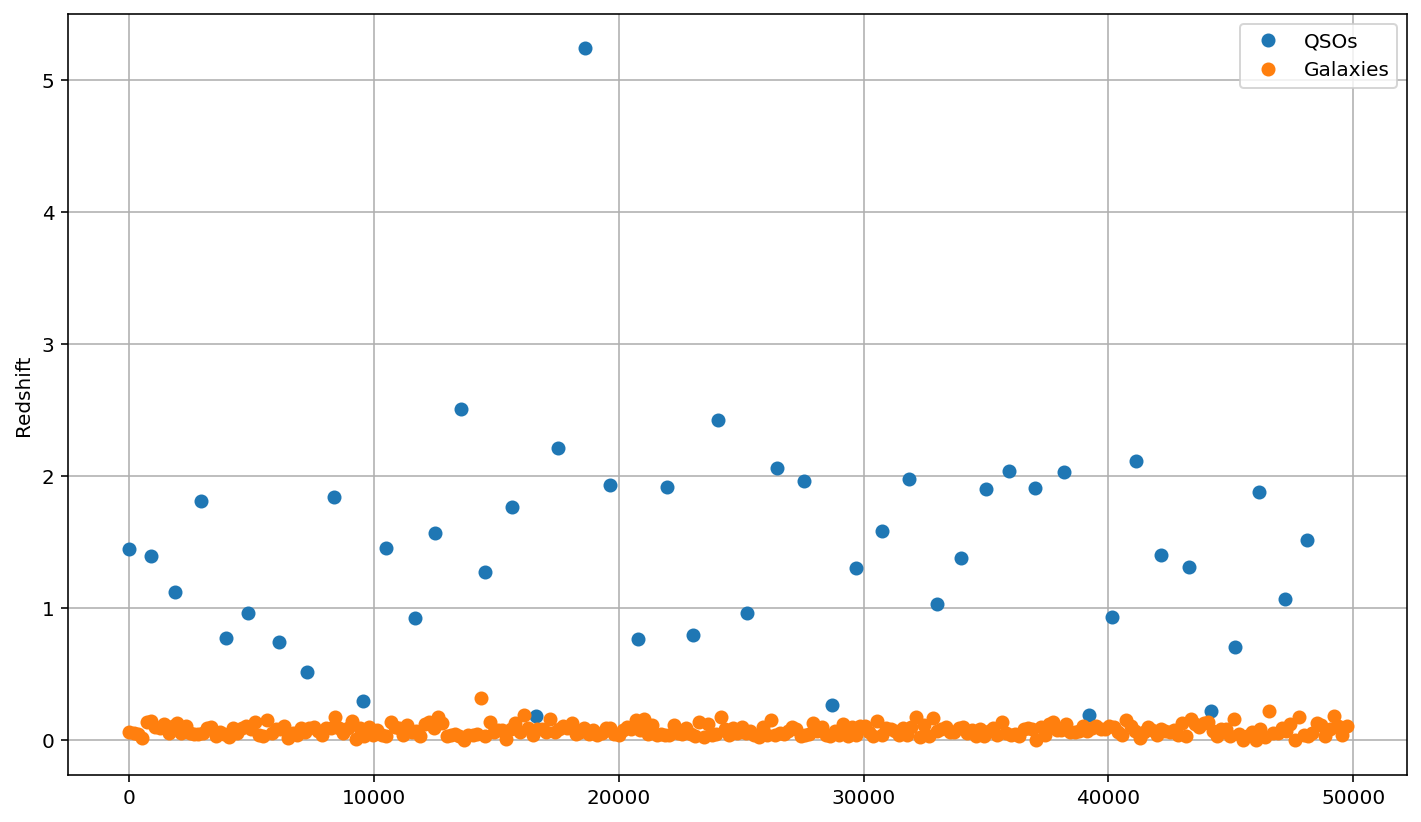

In [4]:
QSOs = data.query('specClass == \'QSO\'')
Galaxies = data.query('specClass == \'GALAXY\'')


plt.plot(QSOs['redshift'][:-150:150], 'o', label='QSOs')
plt.plot(Galaxies['redshift'][:-150:150], 'o', label='Galaxies')
plt.grid()
plt.ylabel('Redshift')
plt.legend()
plt.show()
pass

_Seems as though redshifts can be a great input into telling whether an object is a QSO or galaxy. I've decided to use the redshift data as well as the colours._

**Step 2**: I have the magnitude data but I need the differences in magnitude.
- Simply build a function that will find the differences of my columns

In [5]:
def mod(data):
    '''
    Input
    ------
    data: pandas dataframe
        my pandas array that I want to find the differences of

    Output
    -------
    new data: numpy array
        The new data frame with all of the differences. Also cuts out any columns I'm not interested in applying an operation to.
    '''
    labels = list('ugriz')
    new_labels = [f'{labels[i]} - {labels[i+1]}' for i in range(len(labels)-1)]
    new_data = np.array([data[f'{labels[i]}']-data[f'{labels[i+1]}'] for i in range(len(labels)-1)]).squeeze()
    return new_data.T

pass

**Step 3**: Build my testing and training data set.
 _This involved 3 steps_: 
 - _Step 1: build my feature set with my colours and redshift_
 - _Step 2: scale all of my data since it's always a good idea to do so_
 - _Step 3: I've been given an unbalanced data set so I've used imblearn to under sample and achieve a balanced data set_

In [6]:
Features= np.array([(*x,y) for x,y in zip(mod(data),data['redshift'])]).squeeze()
ScaledFeatures = StandardScaler().fit_transform(Features)
SampledFeatures, SampledClasses = RandomUnderSampler().fit_resample(ScaledFeatures, data['specClass'])


Xtrain, Xtest, ytrain, ytest = train_test_split(SampledFeatures, SampledClasses, train_size=300)

**Step 4**: Training and optimising

_Now to train both my neural network and a random forest classifier then apply some optimisation techniques. I've decided to use a brute force method of using a grid search to ensure maximum prediction accuracy._

**Step 5**: Assessing.

_I use a confusion matrix to assess the performance of my neural network_

# Random Forest

**_Optimisation_**
- _As this is a binary classification problem, the random forest will not be very complex._
- _This means that only a few hyperparameters would actually effect the accuracy of the model._
- _From previous tests it is known that the gini criterion is best_
- _Just need to explore max depth and number of estimators_

In [75]:
param_grid = {
 'min_samples_leaf': np.arange(1,4),
 'max_depth': np.arange(2, 10),
 'n_estimators': np.arange(10,100, 10),
 }

grid = gridsearch(classify(), param_grid)

grid.fit(Xtrain, ytrain)

grid.best_params_

{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 30}

**Testing**


In [76]:
randforest = classify(criterion='gini', max_depth=9, min_samples_leaf=3, n_estimators=30).fit(Xtrain,ytrain)
forestpred = randforest.predict(Xtest)

_Assessing_

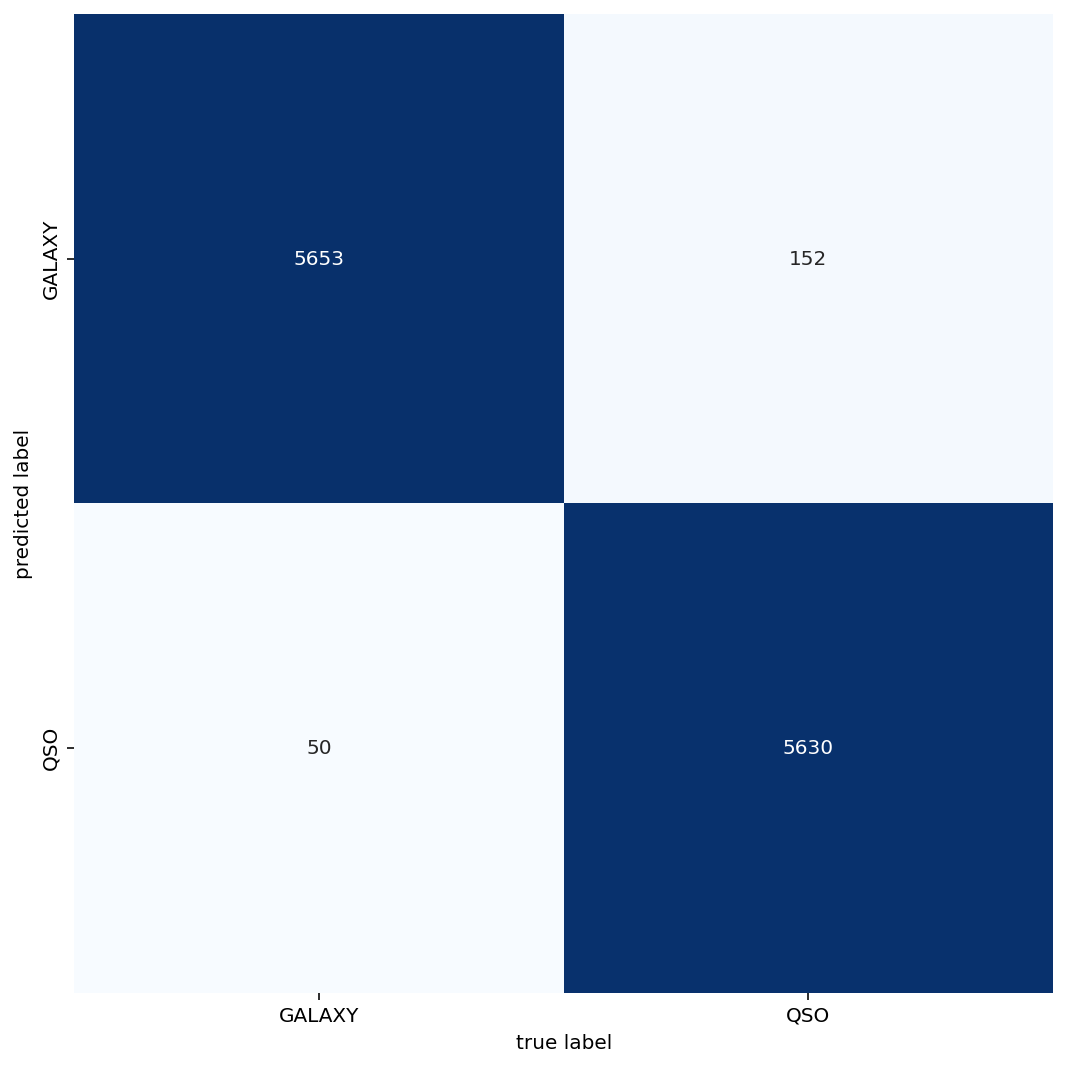

In [77]:

mat = confusion_matrix(ytest, forestpred)

fig = plt.figure(figsize=(9, 9))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels = data['specClass'].unique(), yticklabels = data['specClass'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

# Neural Network

**Optimisation**

_Due to the neural network being a home-brewed solution, I see no other way of optimising the network other than brute force trying different combinations of network parameters manually_

_Training_

In [11]:
neuralnetwork = nl.Network([4])
neuralnetwork.SGD(Xtrain, ytrain, Xtest, ytest, epochs=60, eta=10**-2)

'Training score of:  0.96, Test score of:  0.96'

_Assessing_

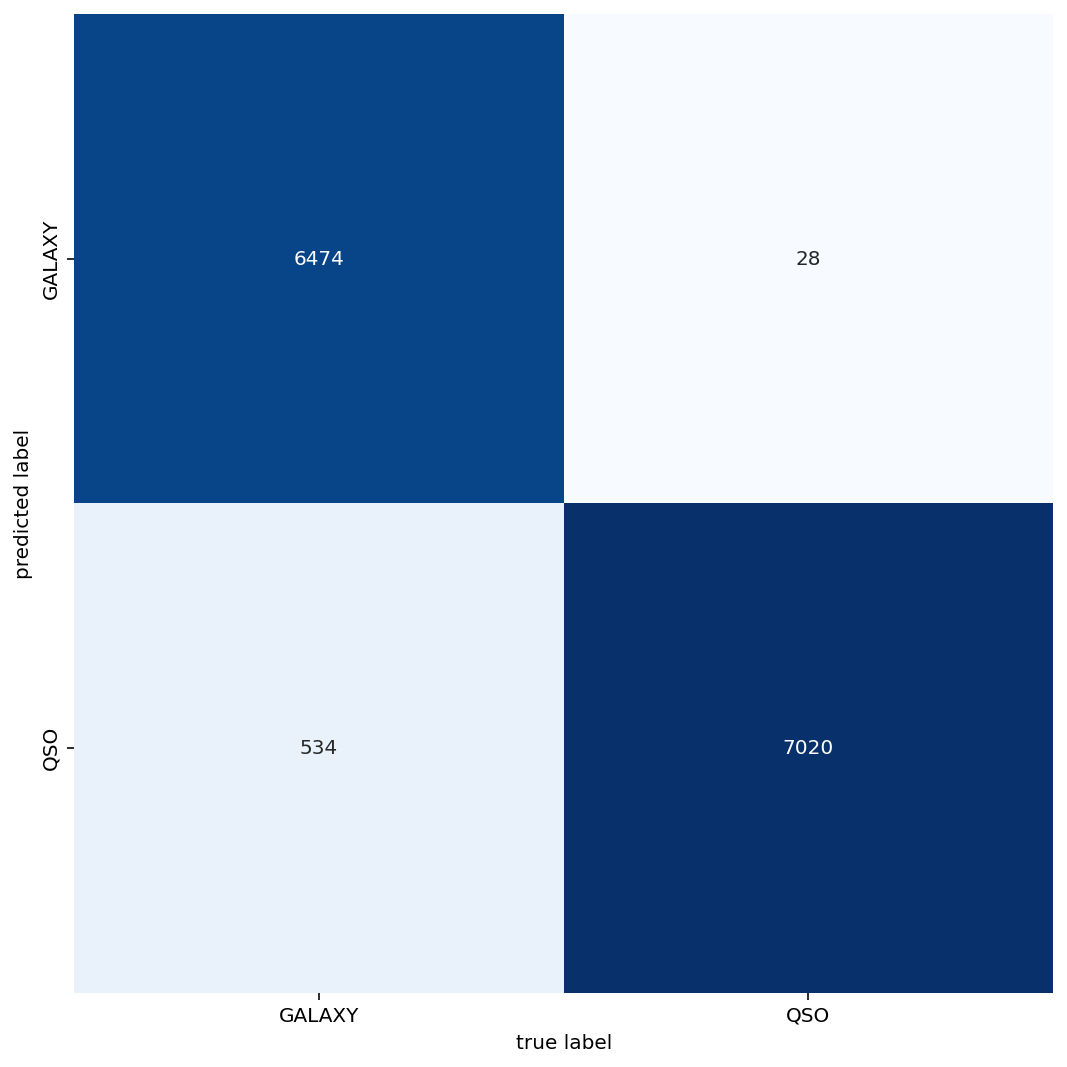

In [12]:
mat = confusion_matrix(neuralnetwork.truths, neuralnetwork.predictions)

fig = plt.figure(figsize=(9, 9))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=neuralnetwork.labels, yticklabels=neuralnetwork.labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

# **Discussion**

While the neural network can achieve incredibly high accuracies (~98%) it does not seem to be the right choice for this task. The network takes longer to train than the random forest classifier, leading to longer optimisation sweeps. Additionally, the neural network has a bad habit of overfitting data and has no method by which to self-correct. This means that sometimes when training the network it will assign all inputs as a single class. Meanwhile the random forest classifier can achieve as good if not better accuracy (~97%) while avoiding these issues.

Despite this, there are key differences in the way the two models make mistakes. The random forest seems to err on the side of caution, having more false negatives than positives (1:3 ratio for false positives to negatives), on the other hand the neural network has the opposite effect outputting more false positives (3:1 ratio for false positives to negatives).